In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

#**IST 707 - Bonus Assignment - Adult Income Prediction**

**By Nisha Rangnani**

**5/8/2020**

This dataset contains information about various details of individuals and aims to predict their income based on different parameters recorded. Income is classified into two categories - <=50K or >50K, that is, income being less than or equal to $50,000 and income greater than $50,000. The dataset consists of 48,842 instances and 15 attributes. It has both numerical and categorical attributes such as age, gender, occupation, number of hours the individual works per week, etc. I aim to classify the class variable, income depending on the input values of various attributes in the dataset.

The dataset can be found at the following link:
https://archive.ics.uci.edu/ml/datasets/adult

**Let us begin by importing various libraries that we'll be using.**

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ShuffleSplit
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier as gbm

**Import the dataset:**

In [0]:
DATASET_PATH = 'gdrive/My Drive/Nisha/MS_ADS/DA/'
TRAIN_PATH = DATASET_PATH + 'adult.csv'

OUTPUT_COL = 'income'
df_train = pd.read_csv(TRAIN_PATH)

**Exploring the dataset:**

In [139]:
df_train.shape

(48842, 15)

**From the above result, we can see that the dataset has 48,842 instances and 15 attributes.** 

**Let us now dive deeper to explore various numerical attributes:**

In [140]:
df_train.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [141]:
df_train.head(7)

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
6,29,?,227026,HS-grad,9,Never-married,?,Unmarried,Black,Male,0,0,40,United-States,<=50K


**Before moving ahead, let us first check if we have any duplicates in our data.**

In [142]:
df_train[df_train.duplicated(subset=None, keep='first')].head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
864,24,Private,194630,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,35,United-States,<=50K
11189,37,Private,52870,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,<=50K
11212,29,Private,36440,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
13848,30,Private,180317,Assoc-voc,11,Divorced,Machine-op-inspct,Not-in-family,White,Male,0,0,40,United-States,<=50K
15960,18,Self-emp-inc,378036,12th,8,Never-married,Farming-fishing,Own-child,White,Male,0,0,10,United-States,<=50K


**From the above output, it is clear that we have duplicate records in our data. Let us deal with duplicates by removing them.**

In [0]:
df_train.drop_duplicates(keep='first',inplace=True)

**From the output of describe(), we can see that at 75% of the data has capital-gain and capital-loss values as zero. Thus, we should drop these columns as they wouldn't help in predicting the income class.**

In [0]:
df_train.drop(labels=['capital-gain', 'capital-loss'], axis=1, inplace=True)

In [145]:
df_train.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,30,United-States,<=50K


**Let us convert our class variable 'income' into a dummy variable column by replacing <=50K income as 0 and >50K income as 1.**

In [0]:
df_train['income'].replace(['<=50K','>50K'],[0,1],inplace=True)

**Exploring the 'Age' attribute:**

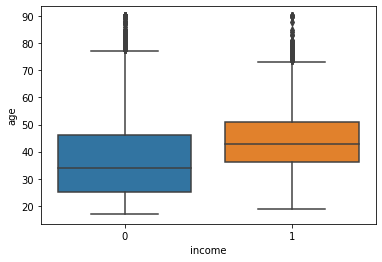

In [148]:
sns.boxplot(x=df_train['income'], y=df_train['age'])

**From the above result, we can see that median age of income <=50K is clearly lesser than median age of individuals who earn more than $50,000.**

**From the data, we can see that education and educational-num represent the same thing in different ways. So, we could drop either column to avoid redundant data.**

In [0]:
df_train.drop(labels=['educational-num'], axis=1, inplace=True)

In [150]:
df_train.education.value_counts()

HS-grad         15770
Some-college    10863
Bachelors        8013
Masters          2656
Assoc-voc        2060
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           954
Prof-school       834
9th               756
12th              655
Doctorate         594
5th-6th           507
1st-4th           245
Preschool          81
Name: education, dtype: int64

**Now since we have so many education levels, we can group these into 3 categories - 1. NoDiploma - People who have not graduated high school. 2. HighSchoolGrad - People who have graduated high school but do not have any degree. 3. Graduated - Who at least have bachelor's or an associate degree.** 

In [0]:
df_train['education'].replace(['HS-grad','Some-college','Prof-school'],['HighSchoolGrad','HighSchoolGrad','HighSchoolGrad'],inplace=True)
df_train['education'].replace(['Bachelors','Masters','Doctorate','Assoc-voc','Assoc-acdm'],['Graduated','Graduated','Graduated','Graduated','Graduated'],inplace=True)
df_train['education'].replace(['Preschool','1st-4th','5th-6th','7th-8th','9th','10th','11th','12th'],['NoDiploma','NoDiploma','NoDiploma','NoDiploma','NoDiploma','NoDiploma','NoDiploma','NoDiploma'],inplace=True)

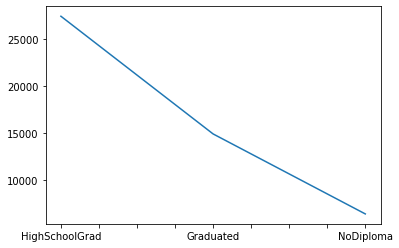

In [152]:
df_train['education'].value_counts().plot()

**From the above plot, we can see that most of our census takers have completed their high school, followed by people who at least hold bachelor's degree.**

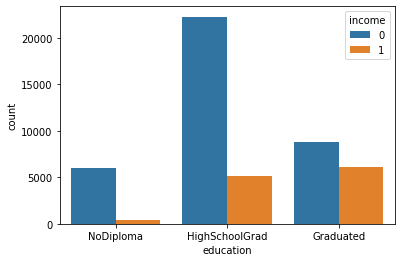

In [153]:
import seaborn as sns
sns.countplot(data=df_train, x='education', hue='income')

**From the above plot, we can notice that as education level increases from no diploma, to high school diploma, to graduates; the percentage of people with income > $50,000 also increases.**

##**Dealing with Null values:**

**From above results, we can also note that Null values are represented by '?' sign. Thus, let us explore data in each of the attributes and deal with null values.**

In [154]:
df_train.workclass.value_counts()

Private             33860
Self-emp-not-inc     3861
Local-gov            3136
?                    2795
State-gov            1981
Self-emp-inc         1694
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64

**About 70% of the population are employed in private sector and about only 5% of the data has nulls. Thus, we can replace '?' with 'Private'.**

In [0]:
df_train['workclass'].replace('?','Private',inplace=True)

**Since we have 8 distinct workclass values, let us group all of them except 'Private' into 3 categories: 1. Unemployed 2. GovtEmployed 3. SelfEmployed.**

In [0]:
df_train['workclass'].replace(['Self-emp-not-inc','Self-emp-inc'],['SelfEmployed','SelfEmployed'],inplace=True)
df_train['workclass'].replace(['Local-gov','State-gov','Federal-gov'],['GovtEmployed','GovtEmployed','GovtEmployed'],inplace=True)
df_train['workclass'].replace(['Without-pay','Never-worked'],['Unemployed','Unemployed'],inplace=True)

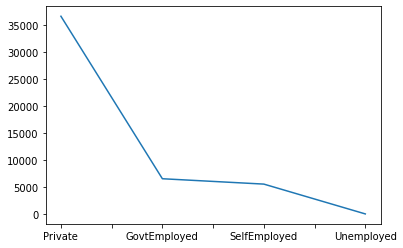

In [157]:
df_train.workclass.value_counts().plot()

**Most of our population is employed in private sector, followed by government jobs and them self-employed.**

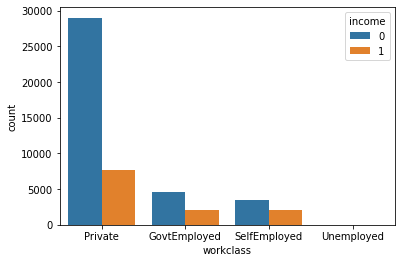

In [158]:
sns.countplot(data=df_train, x='workclass', hue='income')

**At least 50% of government and self employed people earn more than $50,000 per year. The same is not true about the private sector employees.**

**Now that we have dealt with 'workclass' variable, let us move on and explore the next variable - marital-status.**

In [159]:
df_train['marital-status'].value_counts()

Married-civ-spouse       22366
Never-married            16082
Divorced                  6630
Separated                 1530
Widowed                   1518
Married-spouse-absent      627
Married-AF-spouse           37
Name: marital-status, dtype: int64

**From the above result, we can see that there are no nulls in 'marital status' column. However, there are 7 distinct values. Thus, we can group them into - Married, Single.**

In [0]:
df_train['marital-status'].replace(['Married-civ-spouse','Married-spouse-absent', 'Married-AF-spouse'],['Married','Married','Married'],inplace=True)
df_train['marital-status'].replace(['Never-married','Divorced', 'Separated', 'Widowed'],['Single','Single','Single','Single'],inplace=True)

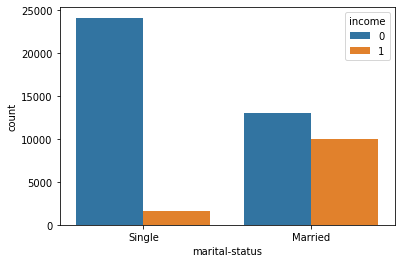

In [161]:
sns.countplot(data=df_train, x='marital-status', hue='income')

**From the above output, we can see that almost equal amount of married people earn lesser than and greater than 50K. However, most of the single people earn <=50K.**

**Let us now move ahead with Country attribute.**

In [162]:
df_train['native-country'].value_counts()

United-States                 43792
Mexico                          943
?                               856
Philippines                     294
Germany                         206
Puerto-Rico                     184
Canada                          182
El-Salvador                     155
India                           151
Cuba                            138
England                         127
China                           122
South                           115
Jamaica                         106
Italy                           105
Dominican-Republic              103
Japan                            92
Poland                           87
Vietnam                          86
Guatemala                        86
Columbia                         85
Haiti                            75
Portugal                         67
Taiwan                           65
Iran                             59
Greece                           49
Nicaragua                        49
Peru                        

**Since we have over 20 countries and 90% of of our data is from United States, we could just retain US data and perform classification over it and delete the native-country column.**

In [0]:
df_train = df_train[df_train['native-country'] == 'United-States']

In [0]:
df_train.drop(labels=['native-country'], axis=1, inplace=True)

**Let us now move ahead with the next attribute - occupation.**

In [165]:
df_train.occupation.value_counts()

Exec-managerial      5602
Prof-specialty       5500
Craft-repair         5496
Adm-clerical         5135
Sales                5075
Other-service        4180
Machine-op-inspct    2557
?                    2536
Transport-moving     2184
Handlers-cleaners    1808
Tech-support         1327
Farming-fishing      1303
Protective-serv       921
Priv-house-serv       154
Armed-Forces           14
Name: occupation, dtype: int64

**We have 14 distinct occupation types and about 5% of them have null values. So let us remove the nulls by replacing with mode occupation and deal with 14 distinct occupations to reduce them to - Service, waged and salaried.**

In [0]:
df_train['occupation'].replace('?','Exec-managerial',inplace=True)

In [0]:
df_train['occupation'].replace(['Tech-support','Priv-house-serv', 'Protective-serv', 'Other-service'],['Service','Service','Service','Service'],inplace=True)
df_train['occupation'].replace(['Farming-fishing','Handlers-cleaners', 'Transport-moving', 'Machine-op-inspct','Adm-clerical','Craft-repair'],['Waged','Waged','Waged','Waged','Waged','Waged'],inplace=True)
df_train['occupation'].replace(['Exec-managerial','Prof-specialty', 'Sales', 'Armed-Forces'],['Salaried','Salaried','Salaried','Salaried'],inplace=True)

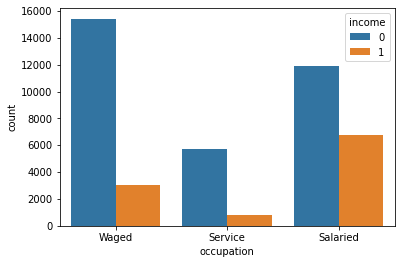

In [168]:
sns.countplot(data=df_train, x='occupation', hue='income')

**From the above plot, it is clear that most of the individuals earning >50K are salaried employees.**

**Let us move ahead to explore 'relationship' attribute.**

In [169]:
df_train.relationship.value_counts()

Husband           17720
Not-in-family     11401
Own-child          7021
Unmarried          4526
Wife               2045
Other-relative     1079
Name: relationship, dtype: int64

**There are no null values in relationship. However, there are 6 distinct relationship types. We could cut these down to two categories - related and single.**

In [0]:
df_train['relationship'].replace(['Husband','Wife', 'Other-relative'],['Related','Related','Related'],inplace=True)
df_train['relationship'].replace(['Not-in-family','Own-child', 'Unmarried'],['Single','Single','Single'],inplace=True)

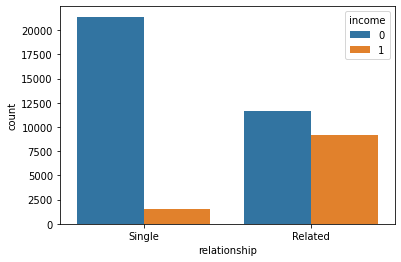

In [171]:
sns.countplot(data=df_train, x='relationship', hue='income')

**Most of the individuals earning >50K are related to others - be it by being married or as other relatives.**

**Moving on to explore 'race' attribute:**

In [172]:
df_train.race.value_counts()

White                 38455
Black                  4268
Amer-Indian-Eskimo      452
Asian-Pac-Islander      428
Other                   189
Name: race, dtype: int64

**There are no nulls in this column. However, there are 5 distinct race values. We can simply club Amer-Indian-Eskimo, Asian-Pac-Islander into the 'Other' category too.**

In [0]:
df_train['race'].replace(['Amer-Indian-Eskimo','Asian-Pac-Islander'],['Other','Other'],inplace=True)

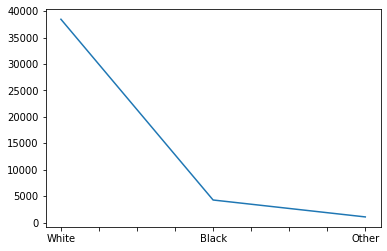

In [174]:
df_train.race.value_counts().plot()

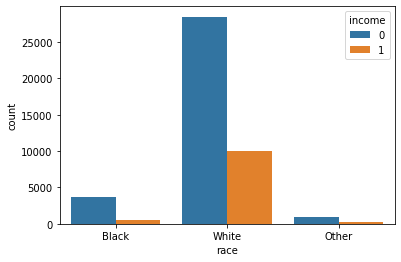

In [175]:
sns.countplot(data=df_train, x='race', hue='income')

**From above two plots, we can see that most of the population is white. In other races, very less percentage of them have income >50K.**

**Exploring the 'gender' column:**

In [176]:
df_train.gender.value_counts()

Male      29196
Female    14596
Name: gender, dtype: int64

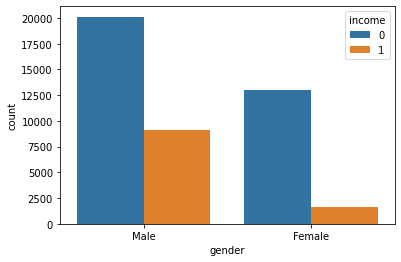

In [177]:
sns.countplot(data=df_train, x='gender', hue='income')

**About 1/3rd men population earn >50K. However, about only 15% of women earn >50K.**

**Column 'fnlwgt' tells the number of people the census takers believe that observation represents. This does not really impact in the identifying if the census-taker will have salary above 50k. Thus, we can drop this column.**

In [0]:
df_train.drop(labels=['fnlwgt'], axis=1, inplace=True)

##**One Hot Encoding:**

In [179]:
dummyVar=['workclass','education','marital-status','occupation','relationship','race','gender']
df_train = pd.get_dummies(df_train, columns=dummyVar, prefix_sep="-")
df_train.head()

,age,hours-per-week,income,workclass-GovtEmployed,workclass-Private,workclass-SelfEmployed,workclass-Unemployed,education-Graduated,education-HighSchoolGrad,education-NoDiploma,marital-status-Married,marital-status-Single,occupation-Salaried,occupation-Service,occupation-Waged,relationship-Related,relationship-Single,race-Black,race-Other,race-White,gender-Female,gender-Male
0,25,40,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,1,0,0,0,1
1,38,50,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0,1,0,1
2,28,40,1,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1
3,44,40,1,0,1,0,0,0,1,0,1,0,0,0,1,1,0,1,0,0,0,1
4,18,30,0,0,1,0,0,0,1,0,0,1,1,0,0,0,1,0,0,1,1,0


**Now, let us move ahead with splitting the data into training set and testing set before moving ahead with implementation of algorithms. I am using 70% of the data for training purpose and the rest 30% of it for validation purpose.**

In [0]:
X = df_train.drop('income', axis=1)
y = df_train['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=16)

##**Logistic Regression**

**Since this is classification problem with two categories in the class variable, I am choosing logistic regression as my base model.**

In [181]:
logr_pipe = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs'))
logr_pipe.fit(X_train,y_train)
y_pred = logr_pipe.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.816105952199726


**Hyperparameter tuning:**

In [69]:
logr= LogisticRegression()
parametersLogr = {'penalty':['l1','l2','elasticnet','none'],'solver': ['liblinear','newton-cg','lbfgs','sag','saga'],'C':[0.01,0.1,1,11.1], 'multi_class':['auto', 'ovr', 'multinomial']}
logr_grid = GridSearchCV(logr, parametersLogr, n_jobs=-1, cv=4)

logr_grid.fit(X_train,y_train)
logr_grid.best_params_

{'C': 0.01, 'multi_class': 'auto', 'penalty': 'l2', 'solver': 'liblinear'}

**Applying the best achieved parameters to predict the testing set.**

In [182]:
finalLogr = LogisticRegression(C=0.01, multi_class='auto', penalty='l2', solver='liblinear')
finalLogr.fit(X_train,y_train)
y_pred = finalLogr.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.8162581823717461


**I created a logistic regression pipeline with lbfgs solver and also performed hyperparameter tuning using gridSearchCV() to find the parameters leading to maximum accuracy. Below is the list of parameters used and their respective accuracies:**

**1. LogisticRegression(solver='lbfgs') : 81.61% accuracy**

**2. LogisticRegression(C=0.01, multi_class='auto', penalty='l2', solver='liblinear') : 81.63% accuracy**

###**Receiver Operating Characteristics:**

In [0]:
def plotROC(pred_mod,X,y):
    mod_proba = pred_mod.predict_proba(X)
    mod_proba = mod_proba[:, 1]
    auc = metrics.roc_auc_score(y, mod_proba)
    print('ROC AUC=%.3f' % (auc))
    fpr, tpr, _ = metrics.roc_curve(y, mod_proba)
    plt.plot(fpr, tpr, marker='.', label='Classifier')
    plt.plot([0, 1], [0, 1],'r--')
    plt.title('ROC Curve')
    plt.xlabel('FPRate')
    plt.ylabel('TPRate')
    plt.legend()
    plt.show()

ROC AUC=0.862


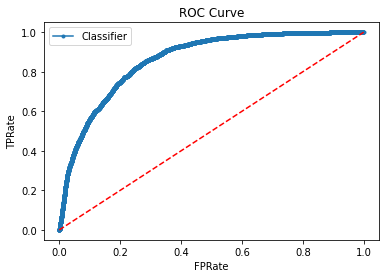

In [184]:
plotROC(logr_grid,X_test, y_test)

**Area under the curve obtained for logistic regression: 0.862.**

##**Gradient Boosting Machine**

**Post using logistic regression as the base model, I decided to use gradient boost as my second model. Gradient boost is a greedy algorithm and often provides accuracy that cannot be beat. It is highly flexible and can be optimized through various loss functions and hyperparameter tuning.**

In [185]:
model_g = gbm()
model_g.fit(X_train,y_train)
gbm_pred = model_g.predict(X_test)
print(accuracy_score(y_test, gbm_pred))

0.8269904094991627


###**Hyperparamter tuning**

In [78]:
gbm = gbm()
parametersGBM = {'learning_rate':[0.02,0.1,0.2], 'loss':['deviance','exponential'], 'n_estimators':[45,75,100,130], 'max_depth':[3,5,9]}
gbm_grid = GridSearchCV(gbm, parametersGBM, n_jobs=-1, cv=4)

gbm_grid.fit(X_train,y_train)
gbm_grid.best_params_

{'learning_rate': 0.2, 'loss': 'deviance', 'max_depth': 3, 'n_estimators': 45}

In [186]:
finalGBM= gbm(learning_rate=0.2, loss='deviance', max_depth=3, n_estimators=45)
finalGBM.fit(X_train,y_train)
y_pred = finalGBM.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.8258486832090121


**I initially ran the default GradientBoostingClassifier() and also performed hyperparameter tuning using gridSearchCV() to find the parameters leading to maximum accuracy. Below is the list of parameters used and their respective accuracies:**

**1. GradientBoostingClassifier() : 82.7% accuracy**

**2. GradientBoostingClassifier(learning_rate=0.2, loss='deviance', max_depth=3, n_estimators=45) : 82.6% accuracy**

ROC AUC=0.881


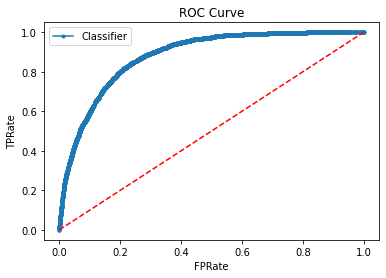

In [187]:
plotROC(model_g,X_test, y_test)

**Area under the curve for ROC: 0.881.**

##**Feature Engineering:**

In [188]:
f_imp_gb = pd.DataFrame(model_g.feature_importances_, index=X.columns, columns=['importance']).sort_values('importance',ascending=False)
f_imp_gb

,importance
marital-status-Single,0.313130
marital-status-Married,0.202612
education-Graduated,0.108220
occupation-Salaried,0.107864
age,0.095557
hours-per-week,0.082189
relationship-Related,0.032089
education-NoDiploma,0.028654
relationship-Single,0.011399
occupation-Waged,0.006296


##**Comparing logistic regression and gradient boosting classifier:**

1. ML algorithm: Logistic Regression, Parameters used: {C=0.01, multi_class='auto', penalty='l2', solver='liblinear'}, Accuracy: 81.6%, Time to run: ~2 seconds

2. ML algorithm: Gradient Boost Machine, Parameters used: default, Accuracy: 82.7%, Time to run: ~5 seconds


**Gradient boosting took slightly higher time to run than logistic regression, but the model provided a better accuracy. It is one of the most flexible algorithms and usually gives an accuracy that cannot be beat.**